## Import necessary libraries

In [ ]:
from typing import List, Dict, Tuple, Mapping, Sequence, Iterator, Literal

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV

from utils import *

import cv2

# Import Dataset

In [ ]:
data_path = './data'

classes = os.listdir(data_path)
class_paths = []

for class_ in classes:
    path = os.path.join(data_path, class_)
    class_paths.append(path)

for i, path in enumerate(class_paths):
    print("There are {} {} images in the dataset.".format(len(os.listdir(path)), classes[i]))

There are 150 danger images in the dataset.
There are 150 instruction images in the dataset.
There are 150 neg images in the dataset.
There are 150 prohibition images in the dataset.


# Sample

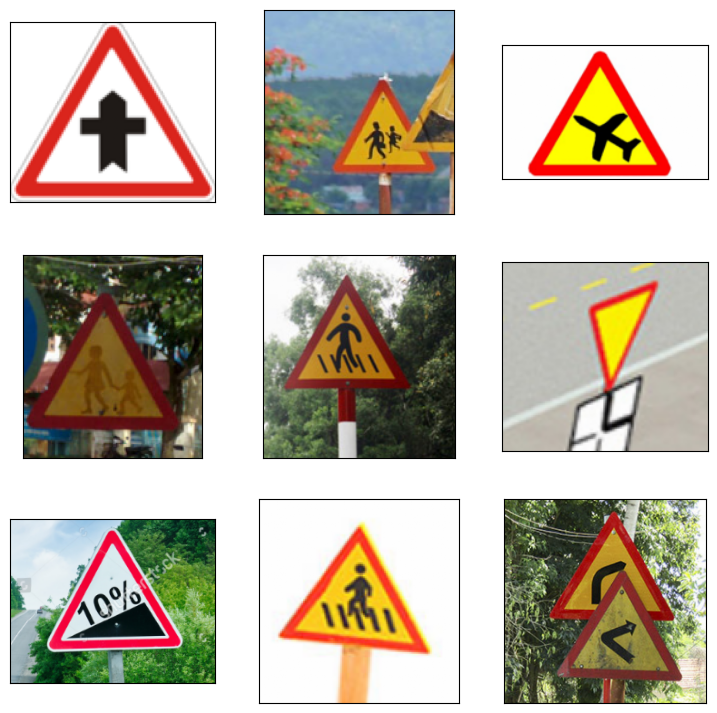

In [ ]:
show(get_image_paths(class_paths[0]), 3, 3)

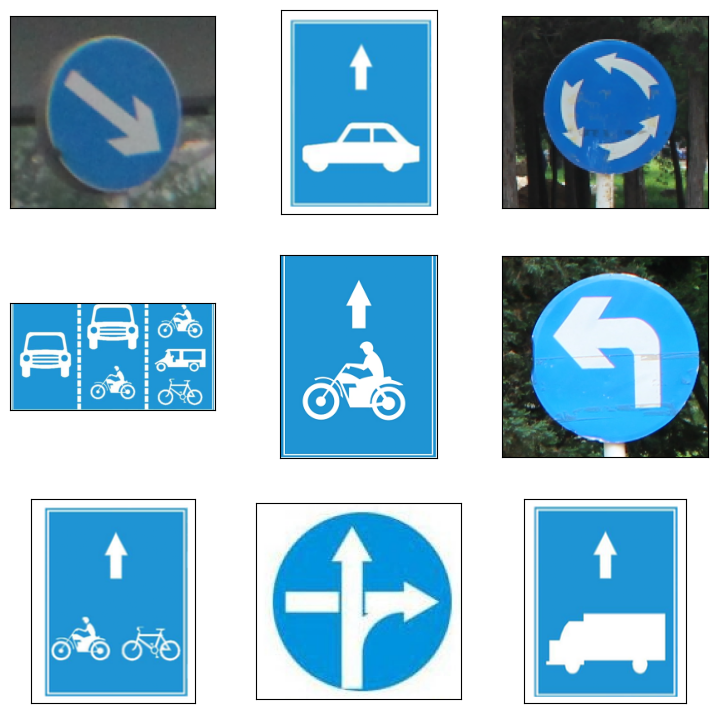

In [ ]:
show(get_image_paths(class_paths[1]), 3, 3)

In [ ]:
def create_samples(class_paths):
    X, y = [], []

    for i, class_path in enumerate(class_paths):
        images = os.listdir(class_path)
        for image in images:
            path = os.path.join(class_path, image)
            arr = cv2.imread(path)
            arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB) / 255.
            X.append(arr.astype(np.float32))
            y.append(i)

    return np.array(X, dtype='object'), np.array(y)

In [ ]:
# Create data samples
X, y = create_samples(class_paths)

# Split into training, development and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = 0.6, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size = 0.5, random_state = 0)

print("There are {} images in training set".format(len(X_train)))
print("There are {} images in validation set".format(len(X_val)))
print("There are {} images in test set".format(len(X_test)))

There are 360 images in training set
There are 120 images in validation set
There are 120 images in test set


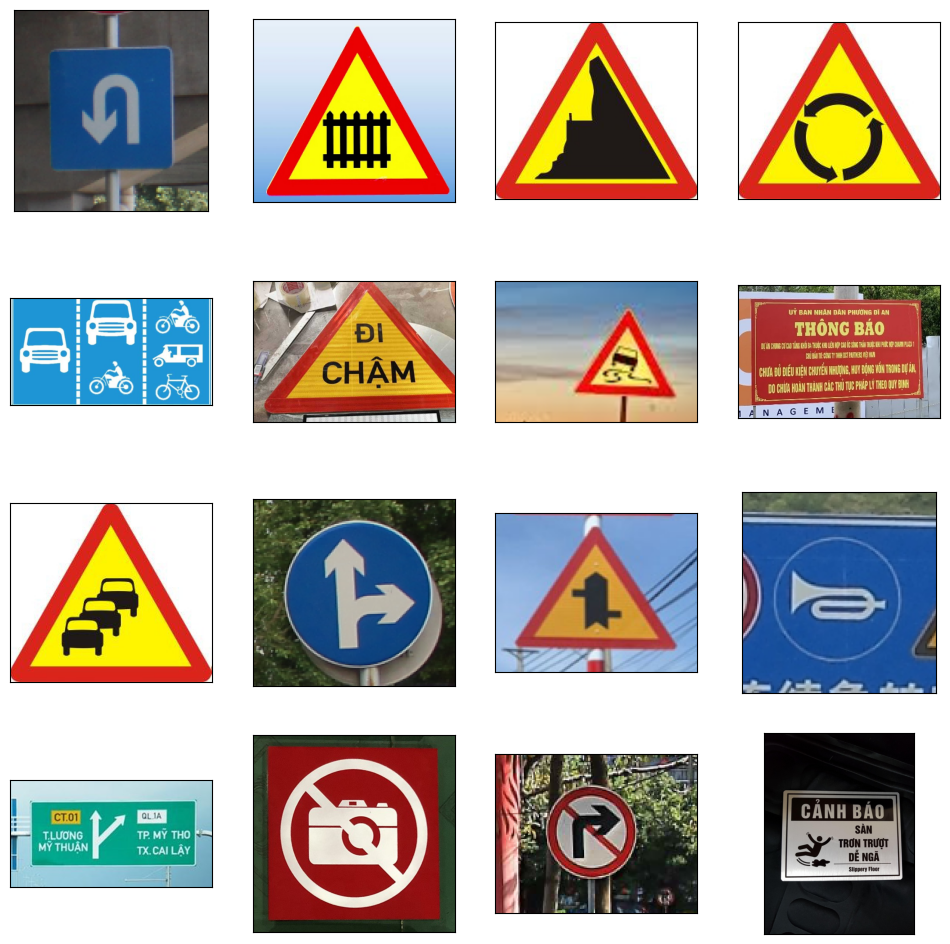

In [ ]:
show(X_train, 4, 4)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# Define a pipeline
pipe = Pipeline(steps=[
    ("scaler", Scaler()),
    ("estimator", KNeighborsClassifier())
])

# Define the parameter grid for GridSearchCV
param_grid_knc = {
    "scaler__scaler_type": ["minmax", "normalize", None],
    "estimator__n_neighbors": [5, 7, 9, 11],
    "estimator__weights": ['uniform', 'distance'],
    "estimator__p": [1, 2]
}

In [ ]:
# Combine training set and validation set for GridSearchCV
X_combine = np.concatenate([X_train, X_val], axis=0)
y_combine = np.concatenate([y_train, y_val], axis=0)

# Create a list where -1 indicates the sample is for training and 0 indicates it's for validation
test_fold = [-1] * len(X_train) + [0] * len(X_val)
ps = PredefinedSplit(test_fold)

In [ ]:
# Apply GridSearchCV to find best model
heading_results = pd.DataFrame([])
target_sizes = [(96, 96), (112, 112), (128, 128)]

for target_size in target_sizes:
    X_combine_hog = []
    for image in X_combine:
        hog_features, _ = compute_hog_features(image, target_size = target_size)
        X_combine_hog.append(hog_features)

    clf = GridSearchCV(pipe, param_grid_knc, cv=ps, return_train_score=True, verbose=2)
    clf.fit(X_combine_hog, y_combine)

    # Get n best results
    n = 5
    temp = heading_key_results(clf, n)
    temp.insert(0, 'target_size', [target_size] * n)
    heading_results = pd.concat([heading_results, temp])

Fitting 1 folds for each of 48 candidates, totalling 48 fits
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=uniform, scaler__scaler_type=minmax; total time=   0.4s
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=uniform, scaler__scaler_type=normalize; total time=   0.3s
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=uniform, scaler__scaler_type=None; total time=   0.2s
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=distance, scaler__scaler_type=minmax; total time=   0.2s
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=distance, scaler__scaler_type=normalize; total time=   0.2s
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=distance, scaler__scaler_type=None; total time=   0.2s
[CV] END estimator__n_neighbors=5, estimator__p=2, estimator__weights=uniform, scaler__scaler_type=minmax; total time=   0.1s
[CV] END estimator__n_neighbors=5, estimator__p=2, e

In [ ]:
heading_results.sort_values(ascending = [False, True], by = ['mean_test_score', 'train_test_diff'])

,target_size,scaler_type,n_neighbors,weights,p,mean_train_score,mean_test_score,train_test_diff,rank_test_score
7,"(128, 128)",normalize,5,uniform,2,0.933333,0.941667,0.008333,1
19,"(128, 128)",normalize,7,uniform,2,0.930556,0.941667,0.011111,1
19,"(96, 96)",normalize,7,uniform,2,0.927778,0.941667,0.013889,1
20,"(96, 96)",None,7,uniform,2,0.927778,0.941667,0.013889,1
20,"(128, 128)",None,7,uniform,2,0.927778,0.941667,0.013889,1
6,"(96, 96)",minmax,5,uniform,2,0.908333,0.941667,0.033333,1
9,"(96, 96)",minmax,5,distance,2,1.000000,0.941667,0.058333,1
22,"(96, 96)",normalize,7,distance,2,1.000000,0.941667,0.058333,1
10,"(128, 128)",normalize,5,distance,2,1.000000,0.941667,0.058333,1
1,"(112, 112)",normalize,5,uniform,1,0.927778,0.933333,0.005556,1


.

## Augment the training data to avoid overfitting

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator class
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='reflect'
)

2024-05-22 09:50:04.527130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
X_augmented = []
y_augmented = []

for i, image in enumerate(X_train):
    image = image.reshape((1,) + image.shape)

    # Specify the number of augmented images for each image
    n = 3
    for batch in data_gen.flow(image, batch_size = 1, seed = 0):
        X_augmented.append(batch[0])
        y_augmented.append(y_train[i])

        n -= 1
        if n == 0: break

X_augmented = np.array(X_augmented, dtype = 'object')
y_augmented = np.array(y_augmented)

print("There are {} augmented images.".format(len(X_augmented)))

There are 1080 augmented images.


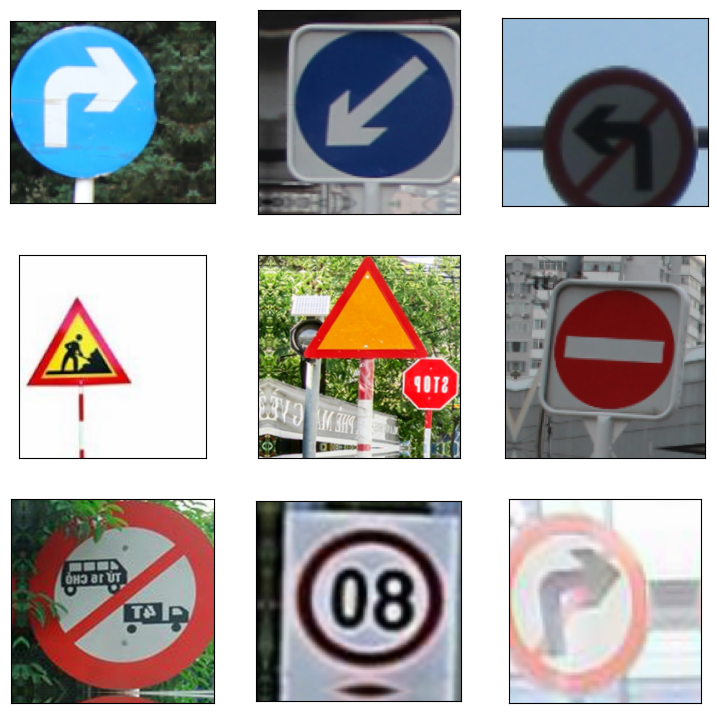

In [ ]:
show(X_augmented, 3, 3, is_random = True)

.

## K-Nearest Neighbors

In [ ]:
# New training set which is a combination of training set and augmented set
X_train2 = np.concatenate([X_train, X_augmented], axis = 0)
y_train2 = np.concatenate([y_train, y_augmented], axis = 0)

# Combine training set, augmented set and validation set for GridSearchCV
X_combine = np.concatenate([X_train2, X_val], axis=0)
y_combine = np.concatenate([y_train2, y_val], axis=0)

In [ ]:
# No augmented
pre1 = HOG_Preprocessing(target_size = (112, 112), scaler_type = 'normalize')
X_train_hog1 = pre1.fit_transform(X_train)
X_val_hog1 = pre1.transform(X_val)

knc1 = KNeighborsClassifier(n_neighbors=9, weights='distance')
knc1.fit(X_train_hog1, y_train)

print("Accuracy on training set:", knc1.score(X_train_hog1, y_train))
print("Accuracy on validation set:", knc1.score(X_val_hog1, y_val))

Accuracy on training set: 1.0
Accuracy on validation set: 0.8916666666666667


In [ ]:
# With augmented
pre2 = HOG_Preprocessing(target_size = (112, 112), scaler_type = 'normalize')
X_train2_hog2 = pre2.fit_transform(X_train2)
X_val_hog2 = pre2.transform(X_val)

knc2 = KNeighborsClassifier(n_neighbors=9, weights='distance')
knc2.fit(X_train2_hog2, y_train2)

print("Accuracy on training set:", knc2.score(X_train2_hog2, y_train2))
print("Accuracy on validation set:", knc2.score(X_val_hog2, y_val))

Accuracy on training set: 0.9756944444444444
Accuracy on validation set: 0.8916666666666667


### Apply GridSearchCV

In [ ]:
# Create a list where -1 indicates the sample is for training and 0 indicates it's for validation
test_fold = [-1] * (len(X_train) + len(X_augmented)) + [0] * len(X_val)
ps = PredefinedSplit(test_fold)

# Apply GridSearchCV to find best model
heading_results = pd.DataFrame([])
target_sizes = [(96, 96), (112, 112), (128, 128)]

for target_size in target_sizes:
    X_combine_hog = []
    for image in X_combine:
        hog_features, _ = compute_hog_features(image, target_size = target_size)
        X_combine_hog.append(hog_features)

    # Apply GridSearchCV
    clf = GridSearchCV(pipe, param_grid_knc, cv=ps, return_train_score=True, verbose=2)
    clf.fit(X_combine_hog, y_combine)

    # Get n first best results
    n = 5
    temp = heading_key_results(clf, n)
    temp.insert(0, 'target_size', [target_size] * n)
    heading_results = pd.concat([heading_results, temp])

Fitting 1 folds for each of 48 candidates, totalling 48 fits
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=uniform, scaler__scaler_type=minmax; total time=   1.9s
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=uniform, scaler__scaler_type=normalize; total time=   1.1s
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=uniform, scaler__scaler_type=None; total time=   0.4s
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=distance, scaler__scaler_type=minmax; total time=   0.6s
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=distance, scaler__scaler_type=normalize; total time=   0.6s
[CV] END estimator__n_neighbors=5, estimator__p=1, estimator__weights=distance, scaler__scaler_type=None; total time=   0.5s
[CV] END estimator__n_neighbors=5, estimator__p=2, estimator__weights=uniform, scaler__scaler_type=minmax; total time=   0.1s
[CV] END estimator__n_neighbors=5, estimator__p=2, e

In [ ]:
heading_results.sort_values(ascending = [False, True], by = ['mean_test_score', 'train_test_diff'])

,target_size,scaler_type,n_neighbors,weights,p,mean_train_score,mean_test_score,train_test_diff,rank_test_score
34,"(128, 128)",normalize,9,distance,2,0.975694,0.908333,0.067361,1
35,"(128, 128)",None,9,distance,2,0.975694,0.900000,0.075694,2
39,"(128, 128)",minmax,11,distance,1,0.975694,0.900000,0.075694,2
41,"(128, 128)",None,11,distance,1,0.975694,0.900000,0.075694,2
47,"(128, 128)",None,11,distance,2,0.975694,0.900000,0.075694,2
21,"(96, 96)",minmax,7,distance,2,0.975694,0.891667,0.084028,1
47,"(96, 96)",None,11,distance,2,0.975694,0.891667,0.084028,1
34,"(112, 112)",normalize,9,distance,2,0.975694,0.891667,0.084028,1
35,"(112, 112)",None,9,distance,2,0.975694,0.891667,0.084028,1
47,"(112, 112)",None,11,distance,2,0.975694,0.891667,0.084028,1


### Choosing the best model for k-NN

In [ ]:
# Create HOG features samples
preprocessor = HOG_Preprocessing(target_size = (128, 128), scaler_type = 'normalize')
X_train2_hog = preprocessor.fit_transform(X_train2, y_train2)
X_train_hog = preprocessor.transform(X_train)
X_val_hog = preprocessor.transform(X_val)
X_test_hog = preprocessor.transform(X_test)

In [ ]:
# Specify k-NN classifier
knc = KNeighborsClassifier(n_neighbors = 9, weights = 'distance', p = 2)
knc.fit(X_train2_hog, y_train2)

print("Accuracy on training set:", knc.score(X_train2_hog, y_train2))
print("Accuracy on validation set:", knc.score(X_val_hog, y_val))

Accuracy on training set: 0.9756944444444444
Accuracy on validation set: 0.9083333333333333


# Support Vector Machine (SVM)

### Apply GridSearchCV

In [ ]:
from sklearn.svm import SVC

# Define a pipeline
svc = SVC()

# Define the parameter grid for GridSearchCV
param_grid_svc = {
    'C': [0.1, 1, 100],
    'gamma': ['scale'],
    'kernel': ['rbf', 'poly'],
}

In [ ]:
X_combine_hog = preprocessor.transform(X_combine)

# Apply GridSearchCV
clf = GridSearchCV(svc, param_grid_svc, cv=ps, return_train_score=True, verbose=2)
clf.fit(X_combine_hog, y_combine)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  13.1s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=  12.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  12.7s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=  12.9s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=  13.1s
[CV] END ....................C=100, gamma=scale, kernel=poly; total time=  13.2s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 100], 'gamma': ['scale'],
                         'kernel': ['rbf', 'poly']},
             return_train_score=True, verbose=2)

In [ ]:
heading_key_results(clf, n = 6)

,C,gamma,kernel,mean_train_score,mean_test_score,train_test_diff,rank_test_score
2,1,scale,rbf,0.898611,0.908333,0.009722,1
1,0.1,scale,poly,0.632639,0.900000,0.267361,2
3,1,scale,poly,0.975000,0.883333,0.091667,3
5,100,scale,poly,0.975694,0.883333,0.092361,3
4,100,scale,rbf,0.975694,0.866667,0.109028,5
0,0.1,scale,rbf,0.396528,0.475000,0.078472,6


### Choosing the best model for SVM

In [ ]:
# Specify SVM classifier
svc = SVC(C=1, kernel='rbf', gamma='scale')
svc.fit(X_train2_hog, y_train2)

print("Accuracy on training set:", svc.score(X_train2_hog, y_train2))
print("Accuracy on validation set:", svc.score(X_val_hog, y_val))

Accuracy on training set: 0.8986111111111111
Accuracy on validation set: 0.9083333333333333


# Decision Tree

### Apply GridSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define a pipeline
dtc = DecisionTreeClassifier()

# Define the parameter grid for GridSearchCV
param_grid_dtc = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : list(range(7, 12)),
    'min_samples_split' : list(range(2, 6)),
    'min_impurity_decrease' : list(np.arange(0, 0.5, 0.1))
}

In [ ]:
# Apply GridSearchCV
clf = GridSearchCV(dtc, param_grid_dtc, cv=ps, return_train_score=True, verbose=2)
clf.fit(X_combine_hog, y_combine)

Fitting 1 folds for each of 200 candidates, totalling 200 fits
[CV] END criterion=gini, max_depth=7, min_impurity_decrease=0.0, min_samples_split=2; total time=   6.4s
[CV] END criterion=gini, max_depth=7, min_impurity_decrease=0.0, min_samples_split=3; total time=   6.9s
[CV] END criterion=gini, max_depth=7, min_impurity_decrease=0.0, min_samples_split=4; total time=   6.9s
[CV] END criterion=gini, max_depth=7, min_impurity_decrease=0.0, min_samples_split=5; total time=   6.8s
[CV] END criterion=gini, max_depth=7, min_impurity_decrease=0.1, min_samples_split=2; total time=   1.1s
[CV] END criterion=gini, max_depth=7, min_impurity_decrease=0.1, min_samples_split=3; total time=   1.2s
[CV] END criterion=gini, max_depth=7, min_impurity_decrease=0.1, min_samples_split=4; total time=   1.3s
[CV] END criterion=gini, max_depth=7, min_impurity_decrease=0.1, min_samples_split=5; total time=   1.4s
[CV] END criterion=gini, max_depth=7, min_impurity_decrease=0.2, min_samples_split=2; total time=

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [7, 8, 9, 10, 11],
                         'min_impurity_decrease': [0.0, 0.1, 0.2,
                                                   0.30000000000000004, 0.4],
                         'min_samples_split': [2, 3, 4, 5]},
             return_train_score=True, verbose=2)

In [ ]:
heading_key_results(clf, n = 10)

,criterion,max_depth,min_samples_split,min_impurity_decrease,mean_train_score,mean_test_score,train_test_diff,rank_test_score
122,entropy,8,4,0.0,0.581944,0.583333,0.001389,1
121,entropy,8,3,0.0,0.581944,0.566667,0.015278,2
120,entropy,8,2,0.0,0.583333,0.566667,0.016667,2
3,gini,7,5,0.0,0.527083,0.550000,0.022917,4
163,entropy,10,5,0.0,0.660417,0.550000,0.110417,4
61,gini,10,3,0.0,0.727083,0.550000,0.177083,4
81,gini,11,3,0.0,0.791667,0.550000,0.241667,4
0,gini,7,2,0.0,0.529167,0.541667,0.012500,8
143,entropy,9,5,0.0,0.609028,0.541667,0.067361,8
160,entropy,10,2,0.0,0.667361,0.541667,0.125694,8


### Choosing the best model for Decision Tree

In [ ]:
# Specify SVM classifier
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=4, min_impurity_decrease=0.0)
dtc.fit(X_train2_hog, y_train2)

print("Accuracy on training set:", dtc.score(X_train2_hog, y_train2))
print("Accuracy on validation set:", dtc.score(X_val_hog, y_val))

Accuracy on training set: 0.5826388888888889
Accuracy on validation set: 0.5666666666666667


In [ ]:
def build(classifiers: list, train_set, val_set, test_set, names: list[str] | None = None):
    X_train, y_train = train_set
    X_val, y_val = val_set
    X_test, y_test = test_set

    X_train_hog = preprocessor.transform(X_train)
    X_val_hog = preprocessor.transform(X_val)
    X_test_hog = preprocessor.transform(X_test)

    confusion_matrices = []
    train_acc, val_acc, test_acc = [], [], []

    for clf in classifiers:
        y_pred = clf.predict(X_test_hog)
        confusion = confusion_matrix(y_true = y_test, y_pred = y_pred)
        confusion_matrices.append(confusion)

        train_acc.append(clf.score(X_train_hog, y_train))
        val_acc.append(clf.score(X_val_hog, y_val))
        test_acc.append(clf.score(X_test_hog, y_test))

    index = names
    columns = ["Train Accuracy", "Validation Accuracy", "Test Accuracy"]
    result_df = pd.DataFrame(zip(train_acc, val_acc, test_acc), index=index, columns=columns)

    return result_df, confusion_matrices

In [ ]:
classifiers = [knc, svc, dtc]
names = ["k-Nearest Neighbors", "Support Vector Machine", "Decision Tree"]

df, confusion_matrices = build(classifiers, (X_train2, y_train2), (X_val, y_val), (X_test, y_test), names)
df

,Train Accuracy,Validation Accuracy,Test Accuracy
k-Nearest Neighbors,0.975694,0.908333,0.833333
Support Vector Machine,0.898611,0.908333,0.875000
Decision Tree,0.582639,0.566667,0.658333


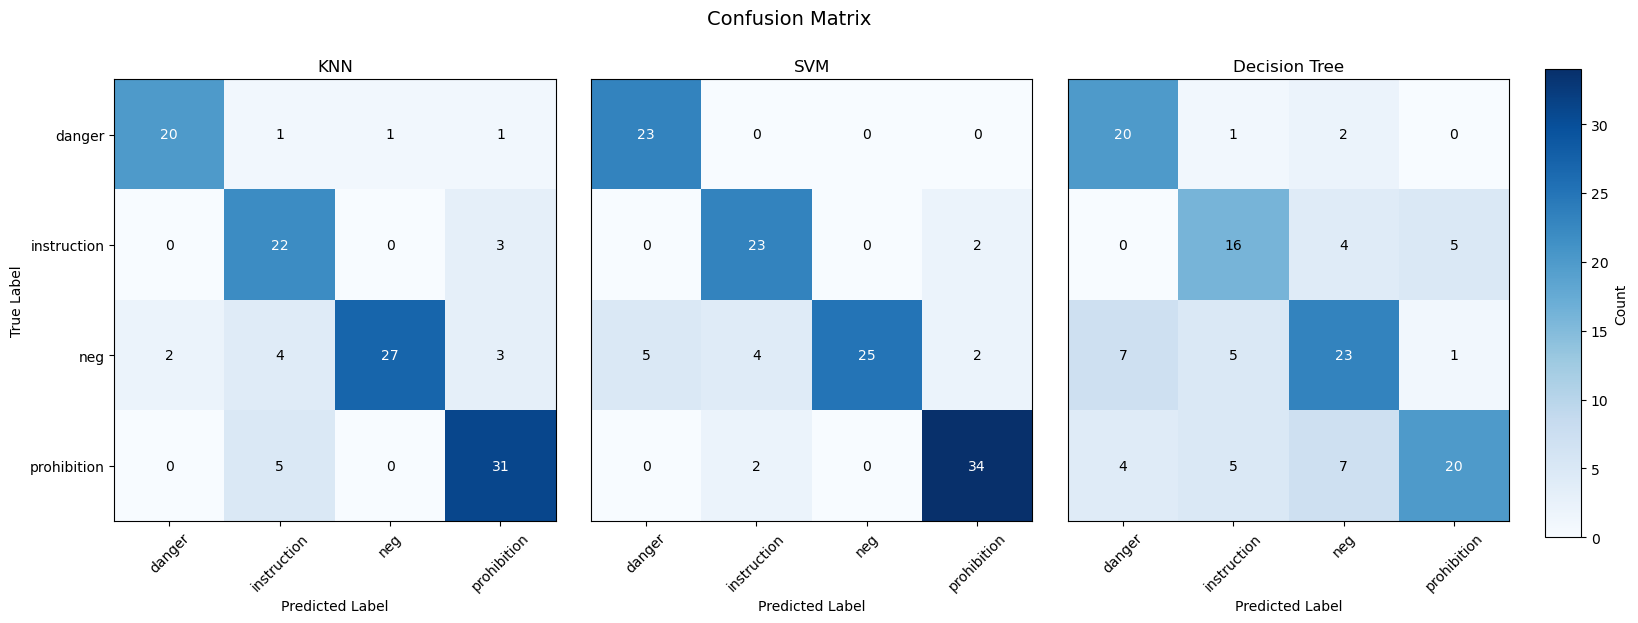

In [ ]:
titles = ["KNN", "SVM", "Decision Tree"]
labels = classes

plot_confusion_matrices(confusion_matrices, titles, labels)

.

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, dtc.predict(X_test_hog))
print(report)

              precision    recall  f1-score   support

           0       0.65      0.87      0.74        23
           1       0.59      0.64      0.62        25
           2       0.64      0.64      0.64        36
           3       0.77      0.56      0.65        36

    accuracy                           0.66       120
   macro avg       0.66      0.68      0.66       120
weighted avg       0.67      0.66      0.66       120



In [ ]:
report = classification_report(y_test, knc.predict(X_test_hog))
print(report)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        23
           1       0.69      0.88      0.77        25
           2       0.96      0.75      0.84        36
           3       0.82      0.86      0.84        36

    accuracy                           0.83       120
   macro avg       0.84      0.84      0.84       120
weighted avg       0.85      0.83      0.84       120



In [ ]:
report = classification_report(y_test, svc.predict(X_test_hog))
print(report)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        23
           1       0.79      0.92      0.85        25
           2       1.00      0.69      0.82        36
           3       0.89      0.94      0.92        36

    accuracy                           0.88       120
   macro avg       0.88      0.89      0.87       120
weighted avg       0.89      0.88      0.87       120



In [ ]:
# Prediction
def predict(clf, image_path, true_label):
    image = plt.imread(image_path)
    hog_features = preprocessor.transform([image])
    pred = clf.predict(hog_features)

    print("True label: ", true_label)
    print(f"Prediction: {classes[pred[0]]}")
    show([image])

In [ ]:
predict(svc, '', "Not signs")

# END.
